The Model learn to extract 2 images from average pixels of them.

# Imports

In [2]:
from random import sample, seed
from time import time

from todels.autoencoder import VAE
from todels.utils import ProgressBar

import torch
import torch.nn as nn
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda:0"):
    print(device, torch.cuda.get_device_name(0))
else:
    print("CPU")

cuda:0 Tesla T4


In [4]:
print("Pytorch version:", torch.__version__)

Pytorch version: 2.0.1+cu118


# Parameters

In [5]:
valid_data_size = 0.1
batch_size = 64
epochs = 10
lr = 0.001
weight_decay = 1e-5
seed(time())

# Load Dataset

In [6]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 13098134.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
class CombineDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, idx):
        i = idx // len(self.dataset1)
        j = idx % len(self.dataset2)
        return (self.dataset1[i], self.dataset2[j])

    def __len__(self):
        return len(self.dataset1) * len(self.dataset2)

In [8]:
train_subset1 = sample(range(1, len(train_data) // 2), 200)
train_subset2 = sample(range(len(train_data) // 2, len(train_data)), 200)
train_subset1 = torch.utils.data.Subset(train_data, train_subset1)
train_subset2 = torch.utils.data.Subset(train_data, train_subset2)
combination_train_datset = CombineDataset(train_subset1, train_subset2)

test_subset1 = sample(range(1, len(test_data) // 2), 50)
test_subset2 = sample(range(len(test_data) // 2, len(test_data)), 50)
test_subset1 = torch.utils.data.Subset(test_data, test_subset1)
test_subset2 = torch.utils.data.Subset(test_data, test_subset2)
combination_test_datset = CombineDataset(test_subset1, test_subset2)

trainloader = torch.utils.data.DataLoader(combination_train_datset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(combination_train_datset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

# Show Samples

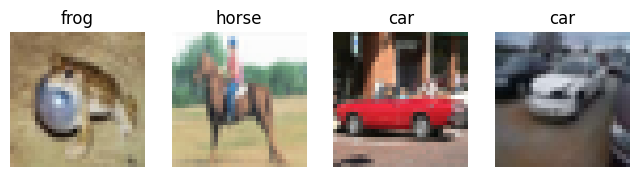

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
for i in range(4):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    ax[i].set_title(classes[train_data[sample_idx][1]])
    ax[i].imshow(train_data[sample_idx][0].swapaxes(0,1).swapaxes(1,2))
    ax[i].axis(False)
plt.show()

# Model

## Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_size = 4096):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Sequential(
                nn.Flatten(),
                nn.LazyLinear(latent_size),
            )
        )

    def forward(self, inputs):
        return self.network(inputs)

## Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_size=4096):
        super(Decoder, self).__init__()
        self.pre_decoder = nn.Sequential(
                nn.Linear(latent_size, 4*4*64),
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        out = self.pre_decoder(inputs)
        out = out.reshape(-1,64,4,4)
        out = self.network(out)
        return out

# Functions Model 1

## Test Function

In [13]:
def test(model, test_loader, loss_function):
    accuracy = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for batch, ((images1, _), (images2, _)) in enumerate(test_loader):
            # move to target device (gpu)
            images1 = images1.to(device, dtype=torch.float32, non_blocking=True)
            images2 = images2.to(device, dtype=torch.float32, non_blocking=True)
            images = (images1 + images2) / 2.
            # predict
            out, mu, var = model(images)
            # cal loss
            total += images.size(0)
            if loss_function is not None:
                recon_loss1 = loss_function(out[0], images1)
                recon_loss2 = loss_function(out[1], images2)
                loss1 = model.cal_loss(recon_loss1, mu[0], var[0], 0.1)
                loss2 = model.cal_loss(recon_loss2, mu[1], var[1], 0.1)
                loss = (loss1 + loss2) / 2.
                running_loss += loss.data
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader)).item()]
    return res

## Train function

In [14]:
def train(model, train_loader, validation_loader, optim, loss_function, epochs, device):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0

    for i in range(epochs):
        pbar = ProgressBar(i+1, n_samples=len(train_loader), length_bar=40)
        running_loss = 0
        model.zero_grad()
        accuracy = 0
        total_size = 0
        for batch, ((images1, _), (images2, _)) in enumerate(train_loader):
            # move to target device (gpu)
            images1 = images1.to(device, dtype=torch.float32, non_blocking=True)
            images2 = images2.to(device, dtype=torch.float32, non_blocking=True)
            images = (images1 + images2) / 2.
            # predict
            out, mu, var = model(images)
            # cal loss
            recon_loss1 = loss_function(out[0], images1)
            recon_loss2 = loss_function(out[1], images2)
            loss1 = model.cal_loss(recon_loss1, mu[0], var[0], 0.1)
            loss2 = model.cal_loss(recon_loss2, mu[1], var[1], 0.1)
            loss = (loss1 + loss2) / 2.
            loss.backward()
            running_loss += loss.data
            # optimazer step
            optim.step()
            model.zero_grad()
            # update progress bar
            pbar.next(batch=batch, addition_output=f"loss={running_loss/(batch+1):>.4f}")

        total_time_train += pbar.take_time
        # append to history
        losses.append((running_loss / len(train_loader)).item())

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)

        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - val_loss = {val_losses[-1]:>.4f}"
        pbar.next(batch=len(train_loader), addition_output=addition_output)

    print(f"----------\n total time for train: {total_time_train / 60.}min")
    return {"loss": losses, "val_loss": val_losses}

## Show Sample Predict

In [15]:
def show_predicts(model, test_data, n_test=4):
    fig, ax = plt.subplots(5, n_test, figsize=(20, 6))
    model.eval()  # Sets the module in evaluation mode not train mode
    with torch.no_grad():
        for i in range(n_test):
            rand_index = int(random() * (len(test_data) - 1))
            (image1, _), (image2, _) = test_data[rand_index]

            ax[0, i].set_title(f"image1")
            ax[0, i].imshow(image1.swapaxes(0,1).swapaxes(1,2))
            ax[0, i].axis(False)

            ax[1, i].set_title(f"image2")
            ax[1, i].imshow(image2.swapaxes(0,1).swapaxes(1,2))
            ax[1, i].axis(False)

            image = (image1 + image2) / 2.
            ax[2, i].set_title(f"combination")
            ax[2, i].imshow(image.swapaxes(0,1).swapaxes(1,2))
            ax[2, i].axis(False)

            image = image.to(device, non_blocking=True)
            image = image.unsqueeze(0)
            (out1, out2), mu, var = model(image)

            ax[3, i].set_title(f"predict image1")
            ax[3, i].imshow(out1.squeeze().swapaxes(0,1).swapaxes(1,2).cpu().numpy())
            ax[3, i].axis(False)

            ax[4, i].set_title(f"predict image2")
            ax[4, i].imshow(out2.squeeze().swapaxes(0,1).swapaxes(1,2).cpu().numpy())
            ax[4, i].axis(False)

    fig.tight_layout()
    plt.show()

# Create Model & Train 1

In [16]:
encoder = Encoder(1024)
decoder = Decoder(1024)
model = VAE(encoder, decoder, [1024, 1024], device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)

In [17]:
history = train(model, trainloader, testloader, optimizer, nn.functional.mse_loss, epochs, device)

 epochs 1: [=======================================>] 100%  time:26.312s - loss = 0.1299 - val_loss = 0.0866
 epochs 2: [=======================================>] 100%  time:17.284s - loss = 0.0634 - val_loss = 0.0728
 epochs 3: [=======================================>] 100%  time:17.966s - loss = 0.0515 - val_loss = 0.0655
 epochs 4: [=======================================>] 100%  time:18.259s - loss = 0.0460 - val_loss = 0.0615
 epochs 5: [=======================================>] 100%  time:17.295s - loss = 0.0427 - val_loss = 0.0569
 epochs 6: [=======================================>] 100%  time:18.377s - loss = 0.0403 - val_loss = 0.0556
 epochs 7: [=======================================>] 100%  time:17.253s - loss = 0.0387 - val_loss = 0.0549
 epochs 8: [=======================================>] 100%  time:17.352s - loss = 0.0375 - val_loss = 0.0536
 epochs 9: [=======================================>] 100%  time:18.364s - loss = 0.0365 - val_loss = 0.0528
 epochs 10: [======

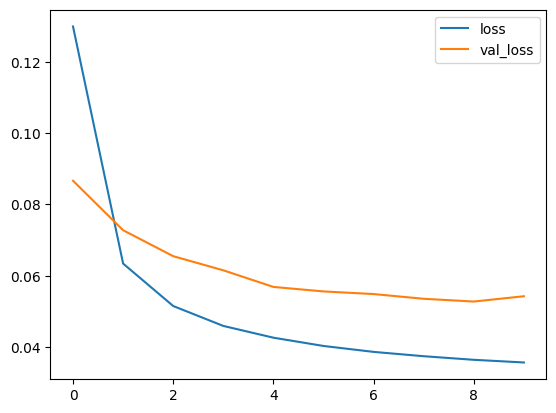

In [18]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.show()

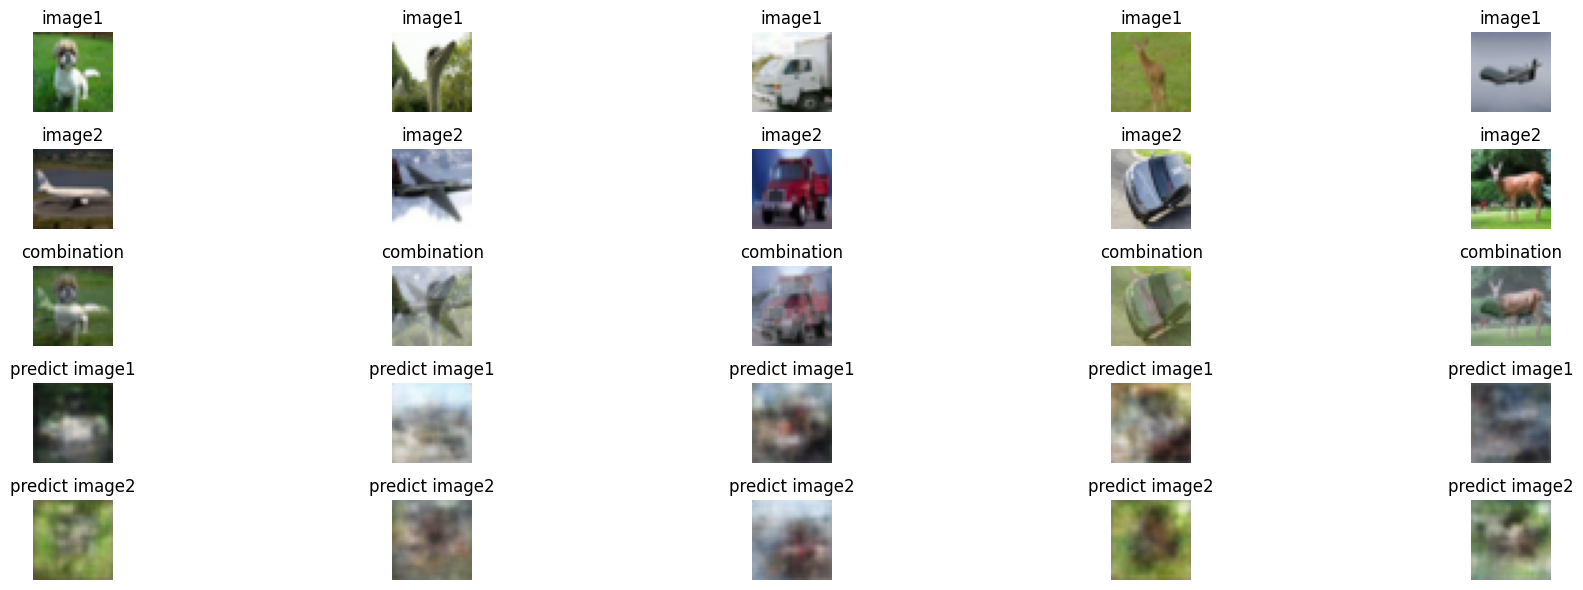

In [19]:
show_predicts(model, combination_test_datset, 5)